In [1]:

from sklearn.metrics import mean_squared_log_error, mean_squared_error

import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, show
import warnings
warnings.simplefilter('ignore')

import os
import gc

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from tqdm.auto import tqdm

from sklearn.preprocessing import LabelEncoder

In [2]:
# 玩家角色表

roles = pd.read_csv('datafountain/role_id.csv')

# 共七天, roles 表填充完整
dfs = []
for i in range(2, 9):
    tmp = roles.copy()
    tmp['day'] = i
    dfs.append(tmp)
data = pd.concat(dfs).reset_index(drop=True)
data

,role_id,create_time,day
0,28b9114a5784b724997257c3,1593268403,2
1,51d43143f0e8c695792ee1d4,1613439868,2
2,52f2bb2665cdb5d81dd245ba,1612927043,2
3,1f3c325b343a3f56b898265e,1614044315,2
4,76d3a7bd0a8ed2b011a99aae,1614056679,2
...,...,...,...
75455,f0f80e12dfa091b5fba71de0,1609603813,8
75456,1cae51d9bd791f6337d1e612,1615136565,8
75457,e6170ea5237741839701d6e6,1615202540,8
75458,42713418593ef32b3f65cc03,1584760818,8


In [3]:
# 货币消耗表
consume = pd.read_csv('datafountain/role_consume_op.csv')
consume['dt'] = pd.to_datetime(consume['dt'])
consume['day'] = consume['dt'].dt.day
consume['hour'] = consume['dt'].dt.hour
consume
# consume['weekday'] = consume['dt'].dt.day_of_week
# 货币消耗按天合并
# TODO: mtime 可以做时差衍生特征, 其他表也是一样的
for i in range(1, 5):
    for m in ['count', 'sum']:
        tmp = consume.groupby(['role_id', 'day'])[f'use_t{i}'].agg(m).to_frame(name=f'use_t{i}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')
# 增加的时差特征        
tmp2 = consume.groupby(['role_id', 'day'])['mtime'].agg('mean').\
    to_frame(name='consume_mtime_avg_day').reset_index()

tmp2['consume_mtime_avg_day'] -= tmp2['consume_mtime_avg_day'].min()
data = data.merge(tmp2, on=['role_id', 'day'], how='left')
data
# consume 

,role_id,create_time,day,use_t1_day_count,use_t1_day_sum,use_t2_day_count,use_t2_day_sum,use_t3_day_count,use_t3_day_sum,use_t4_day_count,use_t4_day_sum,consume_mtime_avg_day
0,28b9114a5784b724997257c3,1593268403,2,1.0,-398.0,1.0,0.0,1.0,0.0,1.0,0.0,29857.758621
1,51d43143f0e8c695792ee1d4,1613439868,2,31.0,135.0,31.0,0.0,31.0,0.0,31.0,0.0,48501.436040
2,52f2bb2665cdb5d81dd245ba,1612927043,2,5.0,-1464.0,5.0,0.0,5.0,0.0,5.0,0.0,42754.558621
3,1f3c325b343a3f56b898265e,1614044315,2,12.0,-20.0,12.0,0.0,12.0,0.0,12.0,0.0,77243.258621
4,76d3a7bd0a8ed2b011a99aae,1614056679,2,5.0,-140.0,5.0,0.0,5.0,0.0,5.0,0.0,3863.758621
...,...,...,...,...,...,...,...,...,...,...,...,...
75455,f0f80e12dfa091b5fba71de0,1609603813,8,14.0,31.0,14.0,0.0,14.0,0.0,14.0,0.0,597022.044335
75456,1cae51d9bd791f6337d1e612,1615136565,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75457,e6170ea5237741839701d6e6,1615202540,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75458,42713418593ef32b3f65cc03,1584760818,8,1.0,-10.0,1.0,0.0,1.0,0.0,1.0,0.0,596045.758621


In [4]:
# 升级表

evolve = pd.read_csv('datafountain/role_evolve_op.csv')
evolve['dt'] = pd.to_datetime(evolve['dt'])
evolve['day'] = evolve['dt'].dt.day
evolve['n_level_up'] = evolve['new_lv'] - evolve['old_lv']
evolve = evolve.rename(columns={'num': 'lv_consume_item_num'})

for col in ['type', 'item_id']:
    for m in ['count', 'nunique']:
        tmp = evolve.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')
for col in ['lv_consume_item_num', 'n_level_up']:
    for m in ['sum', 'mean']:
        tmp = evolve.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')
# 增加的时差特征        
tmp2 = consume.groupby(['role_id', 'day'])['mtime'].agg('mean').\
    to_frame(name='evolve_mtime_avg_day').reset_index()

tmp2['evolve_mtime_avg_day'] -= tmp2['evolve_mtime_avg_day'].min()
data = data.merge(tmp2, on=['role_id', 'day'], how='left')
data

,role_id,create_time,day,use_t1_day_count,use_t1_day_sum,use_t2_day_count,use_t2_day_sum,use_t3_day_count,use_t3_day_sum,use_t4_day_count,use_t4_day_sum,consume_mtime_avg_day,type_day_count,type_day_nunique,item_id_day_count,item_id_day_nunique,lv_consume_item_num_day_sum,lv_consume_item_num_day_mean,n_level_up_day_sum,n_level_up_day_mean,evolve_mtime_avg_day
0,28b9114a5784b724997257c3,1593268403,2,1.0,-398.0,1.0,0.0,1.0,0.0,1.0,0.0,29857.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29857.758621
1,51d43143f0e8c695792ee1d4,1613439868,2,31.0,135.0,31.0,0.0,31.0,0.0,31.0,0.0,48501.436040,49.0,2.0,49.0,4.0,49.0,1.000000,6.0,0.122449,48501.436040
2,52f2bb2665cdb5d81dd245ba,1612927043,2,5.0,-1464.0,5.0,0.0,5.0,0.0,5.0,0.0,42754.558621,5.0,1.0,5.0,1.0,5.0,1.000000,4.0,0.800000,42754.558621
3,1f3c325b343a3f56b898265e,1614044315,2,12.0,-20.0,12.0,0.0,12.0,0.0,12.0,0.0,77243.258621,40.0,2.0,40.0,5.0,40.0,1.000000,15.0,0.375000,77243.258621
4,76d3a7bd0a8ed2b011a99aae,1614056679,2,5.0,-140.0,5.0,0.0,5.0,0.0,5.0,0.0,3863.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3863.758621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75455,f0f80e12dfa091b5fba71de0,1609603813,8,14.0,31.0,14.0,0.0,14.0,0.0,14.0,0.0,597022.044335,32.0,2.0,32.0,2.0,37.0,1.156250,2.0,0.062500,597022.044335
75456,1cae51d9bd791f6337d1e612,1615136565,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75457,e6170ea5237741839701d6e6,1615202540,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75458,42713418593ef32b3f65cc03,1584760818,8,1.0,-10.0,1.0,0.0,1.0,0.0,1.0,0.0,596045.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596045.758621


In [5]:
# 副本表
# TODO: 这个表信息比较多, 可以多挖掘

fb = pd.read_csv('datafountain/role_fb_op.csv')
fb['dt'] = pd.to_datetime(fb['dt'])
fb['day'] = fb['dt'].dt.day
fb['fb_used_time'] = fb['finish_time'] - fb['start_time']
fb['fb_used_time/challenge'] = fb['fb_used_time'] / (fb['challenge_times'] + 1)
fb['fb_used_time*day_times'] = fb['fb_used_time'] * (fb['day_times'] + 1)
for col in ['fb_id', 'fb_type']:
    for m in ['count', 'nunique']:
        tmp = fb.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')
        # 提取副本和副本类型的次数和个数 
for col in ['fb_used_time', 'exp', 'fb_used_time/challenge', 'fb_used_time*day_times']:
    for m in ['sum', 'mean']:
        tmp = fb.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')
        # 提取副本时间和经验的总和与均值 新增：副本时间与挑战点数量的比值
tmp = fb.groupby(['role_id', 'day'])['fb_result'].value_counts().reset_index(name='fb_result_count')
        
for i in [0, 1, 2]:
    tt = tmp[tmp['fb_result'] == i]
    tt.columns = list(tt.columns[:-1]) + ['fb_result%d_count'%i]
    data = data.merge(tt[['role_id', 'day', 'fb_result%d_count'%i]], on=['role_id', 'day'], how='left')
    # 副本收获的总和

data

,role_id,create_time,day,use_t1_day_count,use_t1_day_sum,use_t2_day_count,use_t2_day_sum,use_t3_day_count,use_t3_day_sum,use_t4_day_count,use_t4_day_sum,consume_mtime_avg_day,type_day_count,type_day_nunique,item_id_day_count,item_id_day_nunique,lv_consume_item_num_day_sum,lv_consume_item_num_day_mean,n_level_up_day_sum,n_level_up_day_mean,evolve_mtime_avg_day,fb_id_day_count,fb_id_day_nunique,fb_type_day_count,fb_type_day_nunique,fb_used_time_day_sum,fb_used_time_day_mean,exp_day_sum,exp_day_mean,fb_used_time/challenge_day_sum,fb_used_time/challenge_day_mean,fb_used_time*day_times_day_sum,fb_used_time*day_times_day_mean,fb_result0_count,fb_result1_count,fb_result2_count
0,28b9114a5784b724997257c3,1593268403,2,1.0,-398.0,1.0,0.0,1.0,0.0,1.0,0.0,29857.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29857.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51d43143f0e8c695792ee1d4,1613439868,2,31.0,135.0,31.0,0.0,31.0,0.0,31.0,0.0,48501.436040,49.0,2.0,49.0,4.0,49.0,1.000000,6.0,0.122449,48501.436040,6.0,4.0,6.0,1.0,707.0,117.833333,1.366090e+08,2.276817e+07,342.166667,57.027778,977.0,162.833333,3.0,3.0,NaN
2,52f2bb2665cdb5d81dd245ba,1612927043,2,5.0,-1464.0,5.0,0.0,5.0,0.0,5.0,0.0,42754.558621,5.0,1.0,5.0,1.0,5.0,1.000000,4.0,0.800000,42754.558621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1f3c325b343a3f56b898265e,1614044315,2,12.0,-20.0,12.0,0.0,12.0,0.0,12.0,0.0,77243.258621,40.0,2.0,40.0,5.0,40.0,1.000000,15.0,0.375000,77243.258621,3.0,3.0,3.0,2.0,207.0,69.000000,1.729617e+08,5.765390e+07,185.000000,61.666667,386.0,128.666667,1.0,2.0,NaN
4,76d3a7bd0a8ed2b011a99aae,1614056679,2,5.0,-140.0,5.0,0.0,5.0,0.0,5.0,0.0,3863.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3863.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75455,f0f80e12dfa091b5fba71de0,1609603813,8,14.0,31.0,14.0,0.0,14.0,0.0,14.0,0.0,597022.044335,32.0,2.0,32.0,2.0,37.0,1.156250,2.0,0.062500,597022.044335,3.0,2.0,3.0,1.0,84.0,28.000000,1.702063e+11,5.673544e+10,35.666667,11.888889,160.0,53.333333,1.0,2.0,NaN
75456,1cae51d9bd791f6337d1e612,1615136565,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75457,e6170ea5237741839701d6e6,1615202540,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,1.0,61.0,30.500000,0.000000e+00,0.000000e+00,30.500000,15.250000,122.0,61.000000,NaN,2.0,NaN
75458,42713418593ef32b3f65cc03,1584760818,8,1.0,-10.0,1.0,0.0,1.0,0.0,1.0,0.0,596045.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596045.758621,1.0,1.0,1.0,1.0,124.0,124.000000,0.000000e+00,0.000000e+00,62.000000,62.000000,124.0,124.000000,1.0,NaN,NaN


In [6]:
# 任务系统表

mission = pd.read_csv('datafountain/role_mission_op.csv')
mission['dt'] = pd.to_datetime(mission['dt'])
mission['day'] = mission['dt'].dt.day

for col in ['mission_id', 'mission_type']:
    for m in ['count', 'nunique']:
        tmp = mission.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')
# 增加的时差特征        
tmp2 = mission.groupby(['role_id', 'day'])['mtime'].agg('mean').\
    to_frame(name='mission_mtime_avg_day').reset_index()

tmp2['mission_mtime_avg_day'] -= tmp2['mission_mtime_avg_day'].min()
data = data.merge(tmp2, on=['role_id', 'day'], how='left')        
data

,role_id,create_time,day,use_t1_day_count,use_t1_day_sum,use_t2_day_count,use_t2_day_sum,use_t3_day_count,use_t3_day_sum,use_t4_day_count,use_t4_day_sum,consume_mtime_avg_day,type_day_count,type_day_nunique,item_id_day_count,item_id_day_nunique,lv_consume_item_num_day_sum,lv_consume_item_num_day_mean,n_level_up_day_sum,n_level_up_day_mean,evolve_mtime_avg_day,fb_id_day_count,fb_id_day_nunique,fb_type_day_count,fb_type_day_nunique,fb_used_time_day_sum,fb_used_time_day_mean,exp_day_sum,exp_day_mean,fb_used_time/challenge_day_sum,fb_used_time/challenge_day_mean,fb_used_time*day_times_day_sum,fb_used_time*day_times_day_mean,fb_result0_count,fb_result1_count,fb_result2_count,mission_id_day_count,mission_id_day_nunique,mission_type_day_count,mission_type_day_nunique,mission_mtime_avg_day
0,28b9114a5784b724997257c3,1593268403,2,1.0,-398.0,1.0,0.0,1.0,0.0,1.0,0.0,29857.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29857.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51d43143f0e8c695792ee1d4,1613439868,2,31.0,135.0,31.0,0.0,31.0,0.0,31.0,0.0,48501.436040,49.0,2.0,49.0,4.0,49.0,1.000000,6.0,0.122449,48501.436040,6.0,4.0,6.0,1.0,707.0,117.833333,1.366090e+08,2.276817e+07,342.166667,57.027778,977.0,162.833333,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2,52f2bb2665cdb5d81dd245ba,1612927043,2,5.0,-1464.0,5.0,0.0,5.0,0.0,5.0,0.0,42754.558621,5.0,1.0,5.0,1.0,5.0,1.000000,4.0,0.800000,42754.558621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,9.0,23.0,2.0,42560.793478
3,1f3c325b343a3f56b898265e,1614044315,2,12.0,-20.0,12.0,0.0,12.0,0.0,12.0,0.0,77243.258621,40.0,2.0,40.0,5.0,40.0,1.000000,15.0,0.375000,77243.258621,3.0,3.0,3.0,2.0,207.0,69.000000,1.729617e+08,5.765390e+07,185.000000,61.666667,386.0,128.666667,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
4,76d3a7bd0a8ed2b011a99aae,1614056679,2,5.0,-140.0,5.0,0.0,5.0,0.0,5.0,0.0,3863.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3863.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,4.0,10.0,1.0,3722.550000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75455,f0f80e12dfa091b5fba71de0,1609603813,8,14.0,31.0,14.0,0.0,14.0,0.0,14.0,0.0,597022.044335,32.0,2.0,32.0,2.0,37.0,1.156250,2.0,0.062500,597022.044335,3.0,2.0,3.0,1.0,84.0,28.000000,1.702063e+11,5.673544e+10,35.666667,11.888889,160.0,53.333333,1.0,2.0,NaN,8.0,4.0,8.0,4.0,596349.125000
75456,1cae51d9bd791f6337d1e612,1615136565,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0,12.0,39.0,1.0,521986.724359
75457,e6170ea5237741839701d6e6,1615202540,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,1.0,61.0,30.500000,0.000000e+00,0.000000e+00,30.500000,15.250000,122.0,61.000000,NaN,2.0,NaN,112.0,33.0,112.0,2.0,588037.053571
75458,42713418593ef32b3f65cc03,1584760818,8,1.0,-10.0,1.0,0.0,1.0,0.0,1.0,0.0,596045.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596045.758621,1.0,1.0,1.0,1.0,124.0,124.000000,0.000000e+00,0.000000e+00,62.000000,62.000000,124.0,124.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


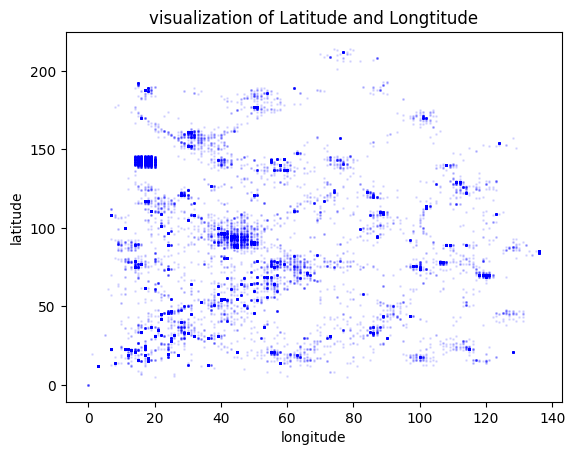

,role_id,create_time,day,use_t1_day_count,use_t1_day_sum,use_t2_day_count,use_t2_day_sum,use_t3_day_count,use_t3_day_sum,use_t4_day_count,use_t4_day_sum,consume_mtime_avg_day,type_day_count,type_day_nunique,item_id_day_count,item_id_day_nunique,lv_consume_item_num_day_sum,lv_consume_item_num_day_mean,n_level_up_day_sum,n_level_up_day_mean,evolve_mtime_avg_day,fb_id_day_count,fb_id_day_nunique,fb_type_day_count,fb_type_day_nunique,fb_used_time_day_sum,fb_used_time_day_mean,exp_day_sum,exp_day_mean,fb_used_time/challenge_day_sum,fb_used_time/challenge_day_mean,fb_used_time*day_times_day_sum,fb_used_time*day_times_day_mean,fb_result0_count,fb_result1_count,fb_result2_count,mission_id_day_count,mission_id_day_nunique,mission_type_day_count,mission_type_day_nunique,mission_mtime_avg_day,reason_day_count,reason_day_nunique,map_id_day_count,map_id_day_nunique,online_durations_day_mean,online_durations_day_sum,map_feature_avg_day
0,28b9114a5784b724997257c3,1593268403,2,1.0,-398.0,1.0,0.0,1.0,0.0,1.0,0.0,29857.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29857.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,1.0,352.500000,705.0,0.097900
1,51d43143f0e8c695792ee1d4,1613439868,2,31.0,135.0,31.0,0.0,31.0,0.0,31.0,0.0,48501.436040,49.0,2.0,49.0,4.0,49.0,1.000000,6.0,0.122449,48501.436040,6.0,4.0,6.0,1.0,707.0,117.833333,1.366090e+08,2.276817e+07,342.166667,57.027778,977.0,162.833333,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,1337.333333,4012.0,0.103533
2,52f2bb2665cdb5d81dd245ba,1612927043,2,5.0,-1464.0,5.0,0.0,5.0,0.0,5.0,0.0,42754.558621,5.0,1.0,5.0,1.0,5.0,1.000000,4.0,0.800000,42754.558621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,9.0,23.0,2.0,42560.793478,3.0,2.0,3.0,1.0,269.666667,809.0,0.598944
3,1f3c325b343a3f56b898265e,1614044315,2,12.0,-20.0,12.0,0.0,12.0,0.0,12.0,0.0,77243.258621,40.0,2.0,40.0,5.0,40.0,1.000000,15.0,0.375000,77243.258621,3.0,3.0,3.0,2.0,207.0,69.000000,1.729617e+08,5.765390e+07,185.000000,61.666667,386.0,128.666667,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,2.0,344.500000,689.0,0.076582
4,76d3a7bd0a8ed2b011a99aae,1614056679,2,5.0,-140.0,5.0,0.0,5.0,0.0,5.0,0.0,3863.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3863.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,4.0,10.0,1.0,3722.550000,1.0,1.0,1.0,1.0,100.000000,100.0,0.151250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75455,f0f80e12dfa091b5fba71de0,1609603813,8,14.0,31.0,14.0,0.0,14.0,0.0,14.0,0.0,597022.044335,32.0,2.0,32.0,2.0,37.0,1.156250,2.0,0.062500,597022.044335,3.0,2.0,3.0,1.0,84.0,28.000000,1.702063e+11,5.673544e+10,35.666667,11.888889,160.0,53.333333,1.0,2.0,NaN,8.0,4.0,8.0,4.0,596349.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75456,1cae51d9bd791f6337d1e612,1615136565,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0,12.0,39.0,1.0,521986.724359,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75457,e6170ea5237741839701d6e6,1615202540,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,1.0,61.0,30.500000,0.000000e+00,0.000000e+00,30.500000,15.250000,122.0,61.000000,NaN,2.0,NaN,112.0,33.0,112.0,2.0,588037.053571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75458,42713418593ef32b3f65cc03,1584760818,8,1.0,-10.0,1.0,0.0,1.0,0.0,1.0,0.0,596045.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596045.758621,1.0,1.0,1.0,1.0,124.0,124.000000,0.000000e+00,0.000000e+00,62.000000,62.000000,124.0,124.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# 玩家离线表
# TODO: 可以做很多时间、坐标方面的特征

offline = pd.read_csv('datafountain/role_offline_op.csv')
offline['dt'] = pd.to_datetime(mission['dt'])
offline['day'] = offline['dt'].dt.day
offline['online_durations'] = offline['offline'] - offline['online']
offline['map_feature'] = (offline['tx'] * offline['ty']) / offline['map_id']
offline['distance'] = np.sqrt(np.sum(np.square(offline['tx'] - offline['ty'])))
plot_data = [[offline['tx'], offline['ty']]]
plt.scatter(offline['tx'], offline['ty'], color='blue', s=1, alpha=0.1)
plt.title('visualization of Latitude and Longtitude')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.show()
for col in ['reason', 'map_id']:
    for m in ['count', 'nunique']:
        tmp = offline.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')
        
for col in ['online_durations']:
    for m in ['mean', 'sum']:
        tmp = offline.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_day_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')
# 增加的时差特征        
tmp2 = offline.groupby(['role_id', 'day'])['map_feature'].agg('mean').\
    to_frame(name='map_feature_avg_day').reset_index()

# tmp2['misson_mtime_avg_day'] -= tmp2['misson_mtime_avg_day'].min()
data = data.merge(tmp2, on=['role_id', 'day'], how='left')   
data


In [8]:
# 付费表

pay = pd.read_csv('datafountain/role_pay.csv')
pay['dt'] = pd.to_datetime(pay['dt'])
pay['day'] = pay['dt'].dt.day
tmp = pay.groupby(['role_id', 'day'])['pay'].agg('sum').to_frame(name='pay_sum_day').reset_index()
data = data.merge(tmp, on=['role_id', 'day'], how='left')
data['pay_sum_day'].fillna(0., inplace=True)

data

,role_id,create_time,day,use_t1_day_count,use_t1_day_sum,use_t2_day_count,use_t2_day_sum,use_t3_day_count,use_t3_day_sum,use_t4_day_count,use_t4_day_sum,consume_mtime_avg_day,type_day_count,type_day_nunique,item_id_day_count,item_id_day_nunique,lv_consume_item_num_day_sum,lv_consume_item_num_day_mean,n_level_up_day_sum,n_level_up_day_mean,evolve_mtime_avg_day,fb_id_day_count,fb_id_day_nunique,fb_type_day_count,fb_type_day_nunique,fb_used_time_day_sum,fb_used_time_day_mean,exp_day_sum,exp_day_mean,fb_used_time/challenge_day_sum,fb_used_time/challenge_day_mean,fb_used_time*day_times_day_sum,fb_used_time*day_times_day_mean,fb_result0_count,fb_result1_count,fb_result2_count,mission_id_day_count,mission_id_day_nunique,mission_type_day_count,mission_type_day_nunique,mission_mtime_avg_day,reason_day_count,reason_day_nunique,map_id_day_count,map_id_day_nunique,online_durations_day_mean,online_durations_day_sum,map_feature_avg_day,pay_sum_day
0,28b9114a5784b724997257c3,1593268403,2,1.0,-398.0,1.0,0.0,1.0,0.0,1.0,0.0,29857.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29857.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,1.0,352.500000,705.0,0.097900,0.0
1,51d43143f0e8c695792ee1d4,1613439868,2,31.0,135.0,31.0,0.0,31.0,0.0,31.0,0.0,48501.436040,49.0,2.0,49.0,4.0,49.0,1.000000,6.0,0.122449,48501.436040,6.0,4.0,6.0,1.0,707.0,117.833333,1.366090e+08,2.276817e+07,342.166667,57.027778,977.0,162.833333,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,1337.333333,4012.0,0.103533,0.0
2,52f2bb2665cdb5d81dd245ba,1612927043,2,5.0,-1464.0,5.0,0.0,5.0,0.0,5.0,0.0,42754.558621,5.0,1.0,5.0,1.0,5.0,1.000000,4.0,0.800000,42754.558621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,9.0,23.0,2.0,42560.793478,3.0,2.0,3.0,1.0,269.666667,809.0,0.598944,0.0
3,1f3c325b343a3f56b898265e,1614044315,2,12.0,-20.0,12.0,0.0,12.0,0.0,12.0,0.0,77243.258621,40.0,2.0,40.0,5.0,40.0,1.000000,15.0,0.375000,77243.258621,3.0,3.0,3.0,2.0,207.0,69.000000,1.729617e+08,5.765390e+07,185.000000,61.666667,386.0,128.666667,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,2.0,344.500000,689.0,0.076582,0.0
4,76d3a7bd0a8ed2b011a99aae,1614056679,2,5.0,-140.0,5.0,0.0,5.0,0.0,5.0,0.0,3863.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3863.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,4.0,10.0,1.0,3722.550000,1.0,1.0,1.0,1.0,100.000000,100.0,0.151250,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75455,f0f80e12dfa091b5fba71de0,1609603813,8,14.0,31.0,14.0,0.0,14.0,0.0,14.0,0.0,597022.044335,32.0,2.0,32.0,2.0,37.0,1.156250,2.0,0.062500,597022.044335,3.0,2.0,3.0,1.0,84.0,28.000000,1.702063e+11,5.673544e+10,35.666667,11.888889,160.0,53.333333,1.0,2.0,NaN,8.0,4.0,8.0,4.0,596349.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
75456,1cae51d9bd791f6337d1e612,1615136565,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0,12.0,39.0,1.0,521986.724359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
75457,e6170ea5237741839701d6e6,1615202540,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,1.0,61.0,30.500000,0.000000e+00,0.000000e+00,30.500000,15.250000,122.0,61.000000,NaN,2.0,NaN,112.0,33.0,112.0,2.0,588037.053571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
75458,42713418593ef32b3f65cc03,1584760818,8,1.0,-10.0,1.0,0.0,1.0,0.0,1.0,0.0,596045.758621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596045.758621,1.0,1.0,1.0,1.0,124.0,124.000000,0.000000e+00,0.000000e+00,62.000000,62.000000,124.0,124.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [9]:
# 验证集设置
# 现在我们可以把问题转为用前n天的行为来预测第n+1天的付费

# 训练集 day 2,3,4,5,6 -> 标签 day 7 pay_sum
df_train = pd.DataFrame({'role_id': data.role_id.unique().tolist()})
for i, d in enumerate(range(2, 7)):
    tmp = data[data.day == d].copy().reset_index(drop=True)
    tmp.drop(['create_time', 'day'], axis=1, inplace=True)
    tmp.columns = ['role_id'] + [f'{c}_day{i}' for c in tmp.columns[1:]]
    df_train = df_train.merge(tmp, on='role_id')

# 验证集 day 3,4,5,6,7 -> 标签 day 8 pay_sum
df_valid = pd.DataFrame({'role_id': data.role_id.unique().tolist()})
for i, d in enumerate(range(3, 8)):
    tmp = data[data.day == d].copy().reset_index(drop=True)
    tmp.drop(['create_time', 'day'], axis=1, inplace=True)
    tmp.columns = ['role_id'] + [f'{c}_day{i}' for c in tmp.columns[1:]]
    df_valid = df_valid.merge(tmp, on='role_id')
    
# 测试集 day 4,5,6,7,8
df_test = pd.DataFrame({'role_id': data.role_id.unique().tolist()})
for i, d in enumerate(range(4, 9)):
    tmp = data[data.day == d].copy().reset_index(drop=True)
    tmp.drop(['create_time', 'day'], axis=1, inplace=True)
    tmp.columns = ['role_id'] + [f'{c}_day{i}' for c in tmp.columns[1:]]
    df_test = df_test.merge(tmp, on='role_id')

    
#标签构造

# 训练集 day == 7 pay_sum
# 验证集 day == 8 pay_sum

day7_pay = pay[pay.day == 7].copy().reset_index(drop=True)
tmp = day7_pay.groupby('role_id')['pay'].agg('sum').to_frame(name='pay').reset_index()
df_train = df_train.merge(tmp, on='role_id', how='left')
df_train['pay'].fillna(0., inplace=True)


day8_pay = pay[pay.day == 8].copy().reset_index(drop=True)
tmp = day8_pay.groupby('role_id')['pay'].agg('sum').to_frame(name='pay').reset_index()
df_valid = df_valid.merge(tmp, on='role_id', how='left')
df_valid['pay'].fillna(0., inplace=True)

In [10]:
df = pd.concat([df_train, df_valid, df_test]).reset_index(drop=True)

df['pay_log'] = np.log1p(df['pay'])

In [11]:

df_train = df[:len(df_train)].reset_index(drop=True)
df_valid = df[len(df_train):len(df_train)+len(df_valid)].reset_index(drop=True)
df_test = df[-len(df_test):].reset_index(drop=True)

In [12]:
label = 'pay_log'
features = [col for col in df_train.columns if col not in ['role_id', 'pay', 'pay_log']]
train_label = df_train[label].values
train_feat = df_train[features]

valid_label = df_valid[label].values
valid_feat = df_valid[features]
gc.collect()

trn_data = lgb.Dataset(train_feat, label=train_label)
val_data = lgb.Dataset(valid_feat, label=valid_label)
callbacks = [lgb.log_evaluation(period=50), lgb.early_stopping(stopping_rounds=120)]
    

In [13]:
from hyperopt import fmin, tpe, hp, partial

In [14]:
# 自定义hyperopt的参数空间
space = {
         "max_depth": hp.randint("max_depth", 15),
         "num_trees": hp.randint("num_trees", 300),
         'learning_rate': hp.uniform('learning_rate', 1e-3, 5e-1),
         "bagging_fraction": hp.randint("bagging_fraction", 5),
         "num_leaves": hp.randint("num_leaves", 6),
}
def argsDict_tranform(argsDict, isPrint=False):
    argsDict["max_depth"] = argsDict["max_depth"] + 5
    argsDict['num_trees'] = argsDict['num_trees'] + 150
    argsDict["learning_rate"] = argsDict["learning_rate"] * 0.02 + 0.05
    argsDict["bagging_fraction"] = argsDict["bagging_fraction"] * 0.1 + 0.5
    argsDict["num_leaves"] = argsDict["num_leaves"] * 3 + 10
    if isPrint:
        print(argsDict)
    else:
        pass

    return argsDict

In [15]:
def lightgbm_factory(argsDict):
    argsDict = argsDict_tranform(argsDict)

    params = {'nthread': -1,  # 进程数
              'max_depth': argsDict['max_depth'],  # 最大深度
              'num_trees': argsDict['num_trees'],  # 树的数量
              'eta': argsDict['learning_rate'],  # 学习率
              'bagging_fraction': argsDict['bagging_fraction'],  # 采样数
              'num_leaves': argsDict['num_leaves'],  # 终点节点最小样本占比的和
              'objective': 'regression',
              'feature_fraction': 0.7,  # 样本列采样
              'lambda_l1': 0,  # L1 正则化
              'lambda_l2': 0,  # L2 正则化
              'bagging_seed': 100,  # 随机种子,light中默认为100
              }
    params['metric'] = ['rmse']
    
    model_lgb = lgb.train(
                    params,
                    trn_data,
                    valid_sets=[trn_data, val_data],
                    callbacks=callbacks
        )
    return get_tranformer_score(model_lgb)
def get_tranformer_score(tranformer):

    model = tranformer
    prediction = model.predict(valid_feat, num_iteration=model.best_iteration)

    return mean_squared_error(df_valid[label], prediction)

In [16]:
# 开始使用hyperopt进行自动调参
algo = partial(tpe.suggest, n_startup_jobs=1)
best = fmin(lightgbm_factory, space, algo=algo, max_evals=20, pass_expr_memo_ctrl=None)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009616 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32374                                                                                     
[LightGBM] [Info] Number of data points in the train set: 10780, number of used features: 202                          
[LightGBM] [Info] Start training from score 0.096794                                                                   
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
Training until validation scores don't improve for 120 rounds                                                          
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                            

In [17]:
RMSE = lightgbm_factory(best)
print('best :', best)
print('best param after transform :')
argsDict_tranform(best,isPrint=True)
print('rmse of the best lightgbm:', np.sqrt(RMSE))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32374
[LightGBM] [Info] Number of data points in the train set: 10780, number of used features: 202
[LightGBM] [Info] Start training from score 0.096794
Training until validation scores don't improve for 120 rounds
[50]	training's rmse: 0.363189	valid_1's rmse: 0.487745
[100]	training's rmse: 0.323927	valid_1's rmse: 0.488965
[150]	training's rmse: 0.302444	valid_1's rmse: 0.48977
Early stopping, best iteration is:
[52]	training's rmse: 0.361158	valid_1's rmse: 0.487224
best : {'bagging_fraction': 0.8, 'learning_rate': 0.05811207069868115, 'max_depth': 13, 'num_leaves': 10, 'num_trees': 364}
best param after transform :
{'bagging_fraction': 0.5800000000000001, 'learning_rate': 0.05116224141397362, 'max_depth': 18, 'num_leaves': 40, 'num_trees': 514}
rmse of the best lightgbm: 0.4872240682380807


In [38]:
params = {
    'objective': 'regression',
    'metric': {'rmse'},
    'boosting_type' : 'gbdt',
    'learning_rate': 0.05,
    'max_depth' : 12,
    'num_leaves' : 32,
    'num_trees': 448,
    'feature_fraction' : 0.7,
    'bagging_fraction': 0.8,
    'min_data_in_leaf': 80,
    'subsample' : 0.75,
    # 'colsample_bytree': 0.9,
    'seed' : 114,
    'num_iterations' : 3000,
    'nthread' : -1,
    'verbose' : -1,
    'device' : 'gpu'
}

features = [col for col in df_train.columns if col not in ['role_id', 'pay', 'pay_log']]
len(features)

230

Training until validation scores don't improve for 120 rounds
[50]	training's rmse: 0.397289	valid_1's rmse: 0.494887
[100]	training's rmse: 0.363937	valid_1's rmse: 0.494868
[150]	training's rmse: 0.339866	valid_1's rmse: 0.495604
Early stopping, best iteration is:
[65]	training's rmse: 0.385532	valid_1's rmse: 0.493379
                                 Feature  importance  importance_gain
43         online_durations_day_sum_day0         163       773.591564
42        online_durations_day_mean_day0          65       138.283663
41               map_id_day_nunique_day0          55       154.452501
229                     pay_sum_day_day4          54      9510.839569
197     lv_consume_item_num_day_sum_day4          35       125.268291
206            fb_used_time_day_sum_day4          35       185.280906
185                  use_t1_day_sum_day4          31       128.086054
40                 map_id_day_count_day0          29       245.462152
196             item_id_day_nunique_day4       

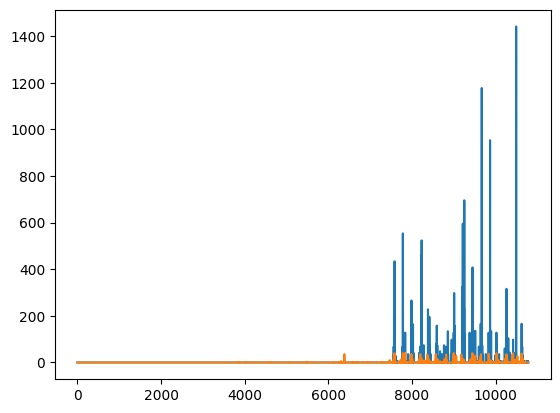

########################rmsle score 0.492754353346927
train_score 0.9565223165972215


In [39]:
def train(df_train, df_valid, label, params, features):
    '''
    训练函数
    '''
    train_label = df_train[label].values
    train_feat = df_train[features]

    valid_label = df_valid[label].values
    valid_feat = df_valid[features]
    gc.collect()

    trn_data = lgb.Dataset(train_feat, label=train_label)
    val_data = lgb.Dataset(valid_feat, label=valid_label)
    callbacks = [lgb.log_evaluation(period=50), lgb.early_stopping(stopping_rounds=120)]
    clf = lgb.train(
                    params,
                    trn_data,
                    valid_sets=[trn_data, val_data],
                    callbacks=callbacks
        )

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    fold_importance_df = fold_importance_df.sort_values(by='importance', ascending=False)
    print(fold_importance_df[:30])
#     fold_importance_df.to_csv(f"importance_df.csv", index=None) 
    df_valid['{}_preds'.format(label)] = clf.predict(valid_feat, num_iteration=clf.best_iteration)
    # 负值修正
    df_valid['{}_preds'.format(label)] = df_valid['{}_preds'.format(label)].clip(lower=0.)
    
    result = mean_squared_log_error(np.expm1(df_valid[label]), 
                                    np.expm1(df_valid['{}_preds'.format(label)]))
    score = 1/(mean_squared_log_error(df_valid[label],df_valid['{}_preds'.format(label)])+1)
#     plot(df_valid[label])
#     plot(df_valid['{}_preds'.format(label)])
#     show()
    plot(np.expm1(df_valid[label]))
    plot(np.expm1(df_valid['{}_preds'.format(label)]))
    show()
    
    return clf, result, score

clf_valid, result_valid, score = train(df_train, df_valid, 'pay_log', params, features)

print('########################rmsle score', np.sqrt(result_valid))
print('train_score', score)


Training until validation scores don't improve for 120 rounds
[50]	training's rmse: 0.4572	valid_1's rmse: 0.4572
[100]	training's rmse: 0.433846	valid_1's rmse: 0.433846
[150]	training's rmse: 0.417023	valid_1's rmse: 0.417023
[200]	training's rmse: 0.403851	valid_1's rmse: 0.403851
[250]	training's rmse: 0.392801	valid_1's rmse: 0.392801
[300]	training's rmse: 0.382591	valid_1's rmse: 0.382591
[350]	training's rmse: 0.374673	valid_1's rmse: 0.374673
[400]	training's rmse: 0.36732	valid_1's rmse: 0.36732
Did not meet early stopping. Best iteration is:
[448]	training's rmse: 0.361832	valid_1's rmse: 0.361832
                                  Feature  importance  importance_gain
197      lv_consume_item_num_day_sum_day4         355       476.944448
187                   use_t2_day_sum_day4         212       302.378812
95                    use_t2_day_sum_day2         206       302.589241
229                      pay_sum_day_day4         205      6390.933100
141                   use_t2_

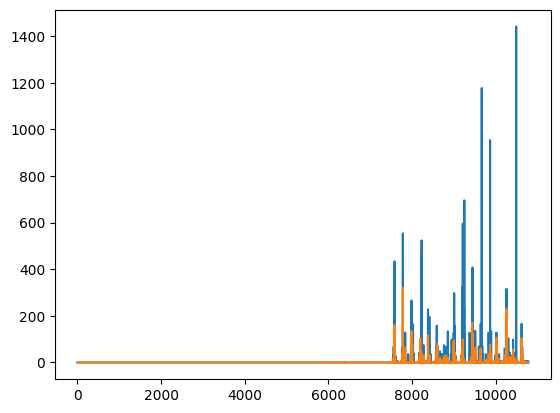

test_score 0.9750533773281955


In [40]:

# 用 4,5,6,7,8 重新训练模型

params['num_iterations'] = clf_valid.best_iteration
clf_test, test_result_valid, test_score = train(df_valid, df_valid, 'pay_log', params, features)
print('test_score', test_score)

In [41]:

df_test['pay'] = np.expm1(clf_test.predict(df_test[features]))
df_test['pay'] = df_test['pay'].clip(lower=0.)
df_test['pay'].describe()

count    10780.000000
mean         0.232597
std          1.549075
min          0.000000
25%          0.007363
50%          0.034264
75%          0.163672
max         45.515331
Name: pay, dtype: float64

In [42]:

sub = pd.read_csv('datafountain/submission_sample.csv')
sub_df = df_test[['role_id', 'pay']].copy()
sub = sub[['role_id']].merge(sub_df, on='role_id', how='left')
sub[['role_id', 'pay']].to_csv('submission.csv', index=False)